In [1]:
import torch
from transformers import CamembertForSequenceClassification, CamembertTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from datasets import Dataset
import numpy as np

In [2]:
df = pd.read_csv('email_complet.csv')

In [3]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
print(f"Taille du DataFrame original : {df.shape[0]}")
print(f"Taille de l'ensemble d'entraînement : {train_df.shape[0]}")
print(f"Taille de l'ensemble de validation : {val_df.shape[0]}")

Taille du DataFrame original : 300000
Taille de l'ensemble d'entraînement : 240000
Taille de l'ensemble de validation : 60000


In [5]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [6]:
model_name = "camembert-base"
tokenizer = CamembertTokenizer.from_pretrained(model_name)
model = CamembertForSequenceClassification.from_pretrained(model_name, num_labels=2, hidden_dropout_prob = 0.3)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def tokenize_function(examples):
    # Tokeniser l'email
    email_encoding = tokenizer(examples['email'], padding="max_length", truncation=True, max_length=64)
    
    # Inclure les autres colonnes comme des features supplémentaires
    other_features = {
        "has_nom": examples["has_nom"],
        "has_prenom": examples["has_prenom"],
        "has_surnom": examples["has_surnom"],
        "has_nom_entreprise": examples["has_nom_entreprise"],
        "has_mot_generique": examples["has_mot_generique"],
        "has_number": examples["has_number"],
    }
    
    # Fusionner les informations supplémentaires dans l'encoding de l'email
    return {**email_encoding, **other_features}

In [8]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/240000 [00:00<?, ? examples/s]

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

In [9]:
training_args = TrainingArguments(
    output_dir='./results',          
    evaluation_strategy="epoch",   
    learning_rate=2e-5,               
    per_device_train_batch_size=64,  
    per_device_eval_batch_size=64,   
    num_train_epochs=10,              
    weight_decay=0.01,                
    save_strategy="epoch",            
    logging_dir='./logs',            
    logging_steps=10,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

/home/soubika/dev/tests/.venv/lib/python3.12/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

In [11]:
log_df = pd.DataFrame(columns=['epoch', 'train_loss', 'eval_loss', 'accuracy'])

def save_metrics(epoch, train_loss, eval_loss, accuracy):
    global log_df
    log_df = log_df.append({'epoch': epoch, 'train_loss': train_loss, 'eval_loss': eval_loss, 'accuracy': accuracy}, ignore_index=True)
    log_df.to_csv('./metrics_log.csv', index=False)


def compute_metrics(p):
    predictions, labels = p
    preds = predictions.argmax(axis=1)
    acc = accuracy_score(labels, preds)
    report = classification_report(labels, preds, output_dict=True)
    return {"accuracy": acc, "classification_report": report}

In [12]:
trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,             
    compute_metrics=compute_metrics,
    tokenizer = tokenizer,
    callbacks=[early_stopping_callback]       
)

/tmp/ipykernel_81010/3568557624.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [13]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Classification Report
1,0.160500,0.069965,0.980617,"{'0': {'precision': 0.9747363579618253, 'recall': 0.9868946248004258, 'f1-score': 0.9807778126704461, 'support': 30064.0}, '1': {'precision': 0.9866716281587227, 'recall': 0.974311865312667, 'f1-score': 0.980452795939291, 'support': 29936.0}, 'accuracy': 0.9806166666666667, 'macro avg': {'precision': 0.980703993060274, 'recall': 0.9806032450565464, 'f1-score': 0.9806153043048685, 'support': 60000.0}, 'weighted avg': {'precision': 0.9806912621053974, 'recall': 0.9806166666666667, 'f1-score': 0.9806156509893817, 'support': 60000.0}}"
2,0.068100,0.049692,0.985667,"{'0': {'precision': 0.984022805621851, 'recall': 0.9874268227780735, 'f1-score': 0.9857218754150617, 'support': 30064.0}, '1': {'precision': 0.9873290426387772, 'recall': 0.9838989845002672, 'f1-score': 0.985611029313345, 'support': 29936.0}, 'accuracy': 0.9856666666666667, 'macro avg': {'precision': 0.9856759241303141, 'recall': 0.9856629036391704, 'f1-score': 0.9856664523642034, 'support': 60000.0}, 'weighted avg': {'precision': 0.985672397477496, 'recall': 0.9856666666666667, 'f1-score': 0.985666570600045, 'support': 60000.0}}"
3,0.051300,0.044230,0.987583,"{'0': {'precision': 0.9866224066390041, 'recall': 0.9886242682277807, 'f1-score': 0.9876223230158334, 'support': 30064.0}, '1': {'precision': 0.9885523012552301, 'recall': 0.9865379476215927, 'f1-score': 0.9875440972396382, 'support': 29936.0}, 'accuracy': 0.9875833333333334, 'macro avg': {'precision': 0.9875873539471172, 'recall': 0.9875811079246868, 'f1-score': 0.9875832101277358, 'support': 60000.0}, 'weighted avg': {'precision': 0.9875852953928598, 'recall': 0.9875833333333334, 'f1-score': 0.9875832935685638, 'support': 60000.0}}"
4,0.043900,0.038486,0.988367,"{'0': {'precision': 0.9876453005645964, 'recall': 0.9891564662054284, 'f1-score': 0.9884003057799049, 'support': 30064.0}, '1': {'precision': 0.9890933422549347, 'recall': 0.9875734901122395, 'f1-score': 0.9883328318791161, 'support': 29936.0}, 'accuracy': 0.9883666666666666, 'macro avg': {'precision': 0.9883693214097655, 'recall': 0.988364978158834, 'f1-score': 0.9883665688295105, 'support': 60000.0}, 'weighted avg': {'precision': 0.9883677768319625, 'recall': 0.9883666666666666, 'f1-score': 0.9883666408016714, 'support': 60000.0}}"
5,0.039400,0.035553,0.988583,"{'0': {'precision': 0.987133145415354, 'recall': 0.9901210750399149, 'f1-score': 0.9886248526212658, 'support': 30064.0}, '1': {'precision': 0.9900485843524879, 'recall': 0.9870390165686799, 'f1-score': 0.9885415098442649, 'support': 29936.0}, 'accuracy': 0.9885833333333334, 'macro avg': {'precision': 0.988590864883921, 'recall': 0.9885800458042974, 'f1-score': 0.9885831812327653, 'support': 60000.0}, 'weighted avg': {'precision': 0.988587755082388, 'recall': 0.9885833333333334, 'f1-score': 0.9885832701317275, 'support': 60000.0}}"
6,0.036500,0.037621,0.988833,"{'0': {'precision': 0.9867845786963434, 'recall': 0.9909858967535924, 'f1-score': 0.9888807753584705, 'support': 30064.0}, '1': {'precision': 0.9909084809447128, 'recall': 0.9866715660074826, 'f1-score': 0.9887854847348688, 'support': 29936.0}, 'accuracy': 0.9888333333333333, 'macro avg': {'precision': 0.9888465298205281, 'recall': 0.9888287313805375, 'f1-score': 0.9888331300466697, 'support': 60000.0}, 'weighted avg': {'precision': 0.9888421309914631, 'recall': 0.9888333333333333, 'f1-score': 0.9888332316900014, 'support': 60000.0}}"
7,0.033600,0.035491,0.989017,"{'0': {'precision': 0.9878554600657, 'recall': 0.9902541245343268, 'f1-score': 0.9890533379844189, 'support': 30064.0}, '1': {'precision': 0.9901885276094163, 'recall': 0.9877739176910743, 'f1-score': 0.9889797488252312, 'support': 29936.0}, 'accuracy': 0.9890166666666667, 'macro avg': {'precision': 0.9890219938375582, 'recall': 0.9890140211127005, 'f1-score': 0.989016543404825, 'support': 60000.0}, 'weighted avg': {'precision': 0.9890195052321782, 'recall': 0.9890166666666667, 'f1-s

In [14]:
train_results = trainer.train(resume_from_checkpoint=True)

/home/soubika/dev/tests/.venv/lib/python3.12/site-packages/transformers/trainer.py:3347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OP

Epoch,Training Loss,Validation Loss


In [15]:
trainer.save_model('./best_model')

In [16]:
trainer.evaluate()

In [17]:
train_metrics = train_results.metrics
df_train_metrics = pd.DataFrame.from_dict(train_metrics, orient="index")
df_train_metrics.to_csv('training_metrics.csv', mode='a', header=False)

In [18]:
test_df = pd.read_csv('dataframe_correction.csv')

In [19]:
def tokenize_function_test(exemples):
    email_encoding = tokenizer(exemples['email'], padding="max_length", truncation=True, max_length=64)
    return email_encoding

In [20]:
test_dataset = Dataset.from_pandas(test_df)
test_dataset = test_dataset.map(tokenize_function_test, batched=True)

Map:   0%|          | 0/18749 [00:00<?, ? examples/s]

In [21]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

In [22]:
conf_matrix = confusion_matrix(labels, preds)
class_report = classification_report(labels, preds, output_dict=True)
class_report

{'0': {'precision': 0.6385893980233602,
  'recall': 0.4535013558781305,
  'f1-score': 0.5303609737897584,
  'support': 6269.0},
 '1': {'precision': 0.7603693082464853,
  'recall': 0.8710737179487179,
  'f1-score': 0.811965492773649,
  'support': 12480.0},
 'accuracy': 0.73145234412502,
 'macro avg': {'precision': 0.6994793531349228,
  'recall': 0.6622875369134242,
  'f1-score': 0.6711632332817037,
  'support': 18749.0},
 'weighted avg': {'precision': 0.7196504295228856,
  'recall': 0.73145234412502,
  'f1-score': 0.7178069387435669,
  'support': 18749.0}}

In [23]:
conf_matrix_df = pd.DataFrame(conf_matrix, index=["0", "1"], columns=["0", "1"])
conf_matrix_df.to_csv('confusion_matrix.csv', index=True)

In [24]:
import matplotlib.pyplot as plt


Matrice de confusion :



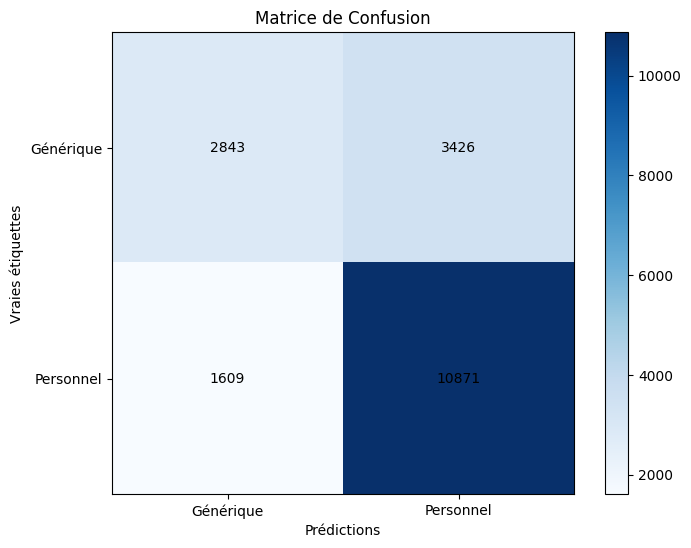

In [25]:
print("\nMatrice de confusion :\n")


plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.xticks([0, 1], ["Générique", "Personnel"])
plt.yticks([0, 1], ["Générique", "Personnel"])
plt.colorbar()

for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

plt.savefig("matrice_de_confusion.png", format="png", dpi=300)
plt.show()

In [26]:
test_df['predicted_label'] = preds
incorrect_predictions = test_df[test_df['predicted_label'] != test_df['label']]
incorrect_predictions.to_csv('incorrect_predictions.csv', index=False)